In [ ]:
import os
import numpy as np
import matplotlib.pyplot as plt
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from keras.optimizers import Adam
from keras.applications import MobileNetV2
from keras.models import Model
from keras.layers import Flatten, Dense, Dropout
from keras.callbacks import EarlyStopping, ReduceLROnPlateau

In [ ]:
import zipfile

zip_path = "/content/drive/MyDrive/DL_Dataset/old_dataset.zip"
extract_path = "/content/dataset"

# Extract the ZIP file
with zipfile.ZipFile(zip_path, 'r') as zip_ref:
    zip_ref.extractall(extract_path)

TRAINING_DIR = "/content/dataset/tomato/train"
VALIDATION_DIR = "/content/dataset/tomato/val"
MODEL_SAVE_PATH = "/content/drive/MyDrive/VGG16_Improv.h5"

In [ ]:
# Parameters
TARGET_SIZE = (160, 160)  # Smaller image size for faster training
TRAIN_BATCH_SIZE = 32
VALID_BATCH_SIZE = 32
EPOCHS = 25
SEED = 42

# Image Augmentation
train_gen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=10,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    fill_mode='nearest'
)

valid_gen = ImageDataGenerator(rescale=1./255)

# Data Loaders
train_data = train_gen.flow_from_directory(
    TRAINING_DIR,
    target_size=TARGET_SIZE,
    class_mode='categorical',
    color_mode="rgb",
    batch_size=TRAIN_BATCH_SIZE,
    shuffle=True,
    seed=SEED
)

valid_data = valid_gen.flow_from_directory(
    VALIDATION_DIR,
    target_size=TARGET_SIZE,
    class_mode='categorical',
    color_mode="rgb",
    batch_size=VALID_BATCH_SIZE
)

Found 10000 images belonging to 10 classes.
Found 1000 images belonging to 10 classes.


In [ ]:
# MobileNetV2 base model with early stopping
base_model = MobileNetV2(weights='imagenet', include_top=False, input_shape=(160, 160, 3))
for layer in base_model.layers:
    layer.trainable = False  # Freeze base model

# Custom head
x = Flatten()(base_model.output)
x = Dense(256, activation='relu')(x)
x = Dropout(0.25)(x)
output = Dense(train_data.num_classes, activation='softmax')(x)
model = Model(inputs=base_model.input, outputs=output)

# Compile
model.compile(optimizer=Adam(learning_rate=0.0001),
              loss='categorical_crossentropy',
              metrics=['accuracy'])

# Callbacks
early_stop = EarlyStopping(patience=3, restore_best_weights=True)
reduce_lr = ReduceLROnPlateau(patience=2, factor=0.5)

# Train
history = model.fit(
    train_data,
    validation_data=valid_data,
    epochs=EPOCHS,
    callbacks=[early_stop, reduce_lr]
)

9406464/9406464 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step


/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/25
313/313 ━━━━━━━━━━━━━━━━━━━━ 288s 898ms/step - accuracy: 0.5474 - loss: 1.4728 - val_accuracy: 0.7830 - val_loss: 0.6078 - learning_rate: 1.0000e-04
Epoch 2/25
313/313 ━━━━━━━━━━━━━━━━━━━━ 291s 929ms/step - accuracy: 0.7787 - loss: 0.6278 - val_accuracy: 0.8390 - val_loss: 0.5240 - learning_rate: 1.0000e-04
Epoch 3/25
313/313 ━━━━━━━━━━━━━━━━━━━━ 307s 881ms/step - accuracy: 0.8220 - loss: 0.5092 - val_accuracy: 0.8520 - val_loss: 0.4534 - learning_rate: 1.0000e-04
Epoch 4/25
313/313 ━━━━━━━━━━━━━━━━━━━━ 286s 914ms/step - accuracy: 0.8412 - loss: 0.4546 - val_accuracy: 0.8390 - val_loss: 0.4461 - learning_rate: 1.0000e-04
Epoch 5/25
313/313 ━━━━━━━━━━━━━━━━━━━━ 286s 912ms/step - accuracy: 0.8537 - loss: 0.4098 - val_accuracy: 0.8670 - val_loss: 0.4065 - learning_rate: 1.0000e-04
Epoch 6/25
313/313 ━━━━━━━━━━━━━━━━━━━━ 293s 936ms/step - accuracy: 0.8716 - loss: 0.3785 - val_accuracy: 0.8570 - val_loss: 0.4069 - learning_rate: 1.0000e-04
Epoch 7/25
313/313 ━━━━━━━━━━━━━━━━━━━━ 

In [ ]:
model.save('/content/drive/MyDrive/Colab Notebooks/MobileNetV2.h5')

In [ ]:
from google.colab import files
files.download('/content/drive/MyDrive/Colab Notebooks/VGG16.h5')

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

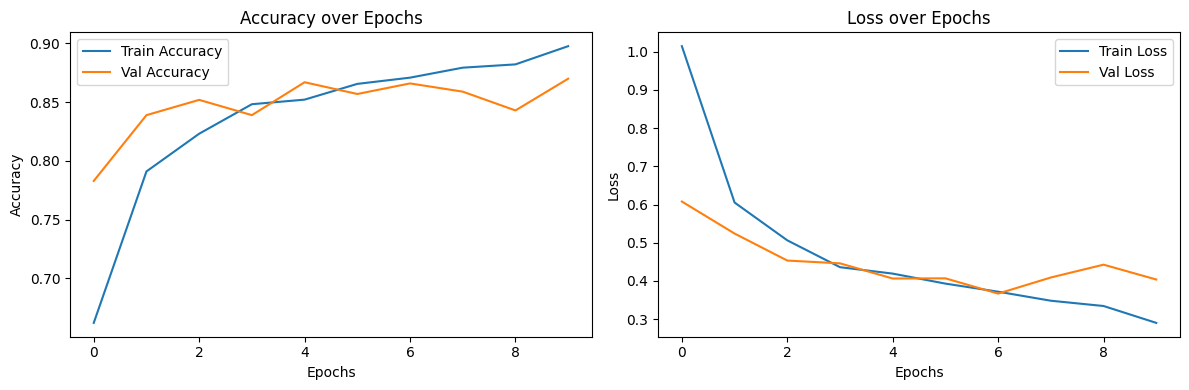

In [ ]:
# Plot training & validation accuracy/loss
plt.figure(figsize=(12, 4))

# Accuracy
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='Train Accuracy')
plt.plot(history.history['val_accuracy'], label='Val Accuracy')
plt.title('Accuracy over Epochs')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

# Loss
plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Val Loss')
plt.title('Loss over Epochs')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.tight_layout()
plt.show()

In [ ]:
final_train_acc = history.history['accuracy'][-1]
final_val_acc = history.history['val_accuracy'][-1]

print(f"Final Training Accuracy: {final_train_acc * 100:.2f}%")
print(f"Final Validation Accuracy: {final_val_acc * 100:.2f}%")

Final Training Accuracy: 89.77%
Final Validation Accuracy: 87.00%


In [ ]:
from keras.applications.vgg16 import VGG16
import math

# Parameters
TARGET_SIZE = (224, 224)
TRAIN_BATCH_SIZE = 128
VALID_BATCH_SIZE = 32
EPOCHS = 25
LEARNING_RATE = 1e-4
SEED = 42

# Data Generators
train_gen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=10,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    fill_mode='nearest'
)

valid_gen = ImageDataGenerator(rescale=1./255)

train_data = train_gen.flow_from_directory(
    TRAINING_DIR,
    target_size=TARGET_SIZE,
    batch_size=TRAIN_BATCH_SIZE,
    class_mode='categorical',
    shuffle=True,
    seed=SEED
)

valid_data = valid_gen.flow_from_directory(
    VALIDATION_DIR,
    target_size=TARGET_SIZE,
    batch_size=VALID_BATCH_SIZE,
    class_mode='categorical'
)

# Load VGG16 base
base_model = VGG16(weights="imagenet", include_top=False, input_shape=(224, 224, 3))

# Add custom head
x = Flatten()(base_model.output)
x = Dense(256, activation="relu")(x)
x = Dropout(0.25)(x)
output = Dense(10, activation='softmax')(x)

model = Model(inputs=base_model.input, outputs=output)

# Optionally freeze base model (for faster training in phase 1)
for layer in base_model.layers:
    layer.trainable = True  # or False to freeze

# Compile model
opt = Adam(learning_rate=LEARNING_RATE)
model.compile(optimizer=opt, loss='categorical_crossentropy', metrics=['accuracy'])

# Train model
STEP_SIZE_TRAIN = math.ceil(train_data.samples / TRAIN_BATCH_SIZE)
STEP_SIZE_VALID = math.ceil(valid_data.samples / VALID_BATCH_SIZE)

history = model.fit(
    train_data,
    steps_per_epoch=STEP_SIZE_TRAIN,
    validation_data=valid_data,
    validation_steps=STEP_SIZE_VALID,
    epochs=EPOCHS
)

Found 10000 images belonging to 10 classes.
Found 1000 images belonging to 10 classes.
Epoch 1/25


KeyboardInterrupt: 